In [2]:
!pwd

/Users/tek/Box/01_HEEH_design/code


# Introduction

The goal is to use the new expanded computational dataset (with ~1500 new features) that was designed 
by Hugh Haddox (Gabe ran the scoring script for me) and determine if any new features are good predictors of protein stability by ks_2sample test


Conclusions:
1. Top 20 features that have the most significant pvaluse (for whether stabilityscore > 1.0) tend to be some feature about hydrophobicity
2. Out of the ~1500 features, only a handful seem to influence the stabilityscore (look at scatter plot)



# Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset

comp = pd.read_csv('../datasets/rd4_rd3_comp_newfeat2.csv')
exp = pd.read_csv('../datasets/rd4_rd3_exp.csv')

# Data preparation

In [18]:
display(exp.head())
display(comp.head())

,Unnamed: 0,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,...,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,topology,stable_06,stable_07,stable_08,stable_09,stable_10
0,6261,HEEH_rd1_0639.pdb,SEEDKKRLEKEANKQPEVTLNGVTVDGRDKKANEKAAEIQEQG,3.0,3.00,3.0,3.0,0.0,2.20,0.81,...,2.79,1.00,0.48,0.39,HEEH,False,False,False,False,False
1,6262,HEEH_rd2_0086.pdb,PTEDIKRKAEKALRNGQTITIGGITVTTEEELRRAEEWLRRQG,3.0,2.97,2.9,3.0,0.1,0.89,2.08,...,0.32,3.60,1.72,0.99,HEEH,True,True,True,True,False
2,6263,HEEH_rd2_0127.pdb,SLEEALERAKEALKKNQPLEVNGYRFDDPRKAYEWAREQLERA,3.0,1.50,1.3,1.7,0.4,1.45,0.05,...,-0.08,2.81,1.34,0.02,HEEH,False,False,False,False,False
3,6264,HEEH_rd2_0129.pdb,PDDLKEKLSRIAKKGGTIEIGNQRYTKPDPELAKKLAEKAQRS,3.0,1.98,1.8,2.2,0.4,1.21,0.77,...,1.98,0.46,0.22,0.22,HEEH,False,False,False,False,False
4,6265,HEEH_rd2_0293.pdb,EANEVVRRAKEALKNGQPFKYGGVEVRTDQDAEELRRILEERS,3.0,3.71,3.6,3.8,0.2,0.52,3.18,...,0.66,1.91,0.91,0.91,HEEH,True,True,True,True,False


,Unnamed: 0,Unnamed: 0.1,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,...,surface_freq_T,surface_freq_V,surface_freq_W,surface_freq_Y,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag,name
0,0,/home/grocklin/test_scoring/HEEH_rd34/HEEH_rd3...,4.0,5.0,-3.0,7.0,5.0,2.0,2.0,0.306297,...,0.130435,0.0,0.0,0.0,-114.686014,8,1.00,4.9879,0.9273,HEEH_rd3_0042.pdb
1,1,/home/grocklin/test_scoring/HEEH_rd34/HEEH_rd4...,1.0,6.0,-6.0,9.0,9.0,3.0,3.0,0.168072,...,0.043478,0.0,0.0,0.0,-107.778623,7,0.50,4.5812,1.1469,HEEH_rd4_0013.pdb
2,2,/home/grocklin/test_scoring/HEEH_rd34/HEEH_rd3...,5.0,2.0,-2.0,5.0,3.0,3.0,1.0,0.294959,...,0.166667,0.0,0.0,0.0,-104.449967,9,0.50,4.0962,0.8781,HEEH_rd3_1602.pdb
3,3,/home/grocklin/test_scoring/HEEH_rd34/HEEH_rd3...,7.0,3.0,-3.0,6.0,2.0,3.0,-1.0,0.303099,...,0.086957,0.0,0.0,0.0,-111.179370,10,0.75,3.9577,0.7179,HEEH_rd3_1263.pdb
4,4,/home/grocklin/test_scoring/HEEH_rd34/HEEH_rd3...,6.0,3.0,-1.0,5.0,3.0,2.0,2.0,0.394676,...,0.125000,0.0,0.0,0.0,-105.372729,9,0.50,3.7214,0.8134,HEEH_rd3_0423.pdb


In [21]:
# drop Unnamed: 0 in exp head
exp = exp.drop(columns = ['Unnamed: 0'])
comp = comp.drop(columns = ['Unnamed: 0'])

In [23]:
# create columns that threshold stabilityscores
exp['stable_06'] = [x > 0.6 for x in exp['stabilityscore']]
exp['stable_07'] = [x > 0.7 for x in exp['stabilityscore']]
exp['stable_08'] = [x > 0.8 for x in exp['stabilityscore']]
exp['stable_09'] = [x > 0.9 for x in exp['stabilityscore']]
exp['stable_10'] = [x > 1.0 for x in exp['stabilityscore']]


# K-S 2 sample test

In [5]:
from scipy.stats import ks_2samp

In [24]:
df = pd.merge(left = comp, right = exp, left_on = 'name', right_on = 'name', how = 'inner')

In [25]:
# loop over every column in df and calculate ks_2samp for each feaure different stability thresholds
# and calculate slope
# store in a list

out=[]
for c in df.columns:
    try:
        # skip non-numeric values
        if type(df[c].values[0]) == type(''):   
            continue
        # skip 0's
        if np.std(df[c]) == 0:
            continue
        # skip columns that produced errors 
        if 'stabilityscore' in c or 'ec50' in c or 'stable' in c: 
            continue

        # K-S test
        s6 = ks_2samp(df[df['stable_06'] == True][c], df[df['stable_06'] == False][c])
        s7 = ks_2samp(df[df['stable_07'] == True][c], df[df['stable_07'] == False][c])
        s8 = ks_2samp(df[df['stable_08'] == True][c], df[df['stable_08'] == False][c])
        s9 = ks_2samp(df[df['stable_09'] == True][c], df[df['stable_09'] == False][c])
        s10 = ks_2samp(df[df['stable_10'] == True][c], df[df['stable_10'] == False][c])
    
        #print(c,': ks_2samp pvalue = ', s6[1])

        
        # find linear slope between a feature and the stability score
        reg = np.polyfit(df[c], df['stabilityscore'], 1)
        #print(c, reg[0])

        out.append((c, s6[1], s7[1], s8[1], s9[1], s10[1], reg[0]*np.std(df[c])))
    except:
        pass
    


In [26]:
# create ss_pvals df that has stability scores for each feature based on certain thresholds
ss_pvals = pd.DataFrame(out)
ss_pvals.columns = ('feature','s>06','s>07', 's>08', 's>09', 's>10', 'norm_slope')
ss_pvals['abs_norm'] = np.abs(ss_pvals['norm_slope'])

In [27]:
display(ss_pvals.sort_values('s>06').head(10))
display(ss_pvals.sort_values('s>07').head(10))
display(ss_pvals.sort_values('s>08').head(10))
display(ss_pvals.sort_values('s>09').head(10))
display(ss_pvals.sort_values('s>10').head(20))

,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,8.422970e-06,0.089986,0.089986
1088,n_IL_3d_contacts_5A,2.409184e-13,9.319119e-08,3.307975e-05,1.323417e-03,2.193467e-04,0.063225,0.063225
329,buried_np_AFILMVWY,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
330,buried_np_AFILMVWY_per_res,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
333,buried_npsa_FAMILYVW,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
1087,n_IL_3d_contacts_3A,1.766987e-11,1.265719e-06,2.154829e-05,1.075356e-04,4.213425e-04,0.055733,0.055733
1112,n_KL_3d_contacts_5A,2.932982e-10,5.882146e-07,7.898438e-07,8.903689e-05,6.666361e-04,0.065223,0.065223
839,hydrophobicity,3.713821e-10,5.482967e-08,1.585723e-07,1.089055e-06,3.610508e-05,0.058010,0.058010
1383,percent_hydrophobic_boundary,5.967384e-10,6.453126e-08,1.080625e-08,7.307211e-05,1.895841e-04,0.038762,0.038762
602,freq_L,1.066941e-09,2.309131e-06,3.695273e-07,2.785148e-04,3.748968e-04,0.066045,0.066045


,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
329,buried_np_AFILMVWY,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
330,buried_np_AFILMVWY_per_res,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
333,buried_npsa_FAMILYVW,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,8.422970e-06,0.089986,0.089986
420,exposed_npsa,3.426533e-09,4.325494e-09,2.861119e-09,1.098183e-06,5.661704e-06,0.072175,0.072175
839,hydrophobicity,3.713821e-10,5.482967e-08,1.585723e-07,1.089055e-06,3.610508e-05,0.058010,0.058010
1383,percent_hydrophobic_boundary,5.967384e-10,6.453126e-08,1.080625e-08,7.307211e-05,1.895841e-04,0.038762,0.038762
1088,n_IL_3d_contacts_5A,2.409184e-13,9.319119e-08,3.307975e-05,1.323417e-03,2.193467e-04,0.063225,0.063225
112,avg_per_res_energy_of_site_36_neighborhood_5A,3.607840e-06,5.346792e-07,1.992648e-04,7.010442e-04,3.763645e-04,-0.007443,0.007443
1112,n_KL_3d_contacts_5A,2.932982e-10,5.882146e-07,7.898438e-07,8.903689e-05,6.666361e-04,0.065223,0.065223


,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,8.422970e-06,0.089986,0.089986
330,buried_np_AFILMVWY_per_res,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
329,buried_np_AFILMVWY,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
333,buried_npsa_FAMILYVW,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
420,exposed_npsa,3.426533e-09,4.325494e-09,2.861119e-09,1.098183e-06,5.661704e-06,0.072175,0.072175
1383,percent_hydrophobic_boundary,5.967384e-10,6.453126e-08,1.080625e-08,7.307211e-05,1.895841e-04,0.038762,0.038762
1134,n_LL_3d_contacts_5A,1.287622e-09,1.099920e-06,8.055323e-08,6.033203e-07,1.154571e-06,0.052870,0.052870
839,hydrophobicity,3.713821e-10,5.482967e-08,1.585723e-07,1.089055e-06,3.610508e-05,0.058010,0.058010
602,freq_L,1.066941e-09,2.309131e-06,3.695273e-07,2.785148e-04,3.748968e-04,0.066045,0.066045
1380,percent_hydrophobic_AFILMVWY_boundary,1.967306e-07,2.522218e-06,6.830756e-07,1.323417e-03,1.200040e-04,0.062695,0.062695


,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
329,buried_np_AFILMVWY,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
330,buried_np_AFILMVWY_per_res,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
333,buried_npsa_FAMILYVW,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,8.422970e-06,0.089986,0.089986
1134,n_LL_3d_contacts_5A,1.287622e-09,1.099920e-06,8.055323e-08,6.033203e-07,1.154571e-06,0.052870,0.052870
839,hydrophobicity,3.713821e-10,5.482967e-08,1.585723e-07,1.089055e-06,3.610508e-05,0.058010,0.058010
420,exposed_npsa,3.426533e-09,4.325494e-09,2.861119e-09,1.098183e-06,5.661704e-06,0.072175,0.072175
334,buried_npsa_FAMILYVW_boundary,1.738809e-08,9.082968e-07,1.225168e-06,3.257869e-06,6.086853e-07,0.050940,0.050940
332,buried_npsa,1.863460e-06,1.411814e-05,2.670934e-05,4.287993e-06,8.032207e-06,0.027657,0.027657
331,buried_np_per_res,3.518345e-07,2.636567e-06,1.065335e-05,6.945761e-06,1.843843e-05,0.029595,0.029595


,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
334,buried_npsa_FAMILYVW_boundary,1.738809e-08,9.082968e-07,1.225168e-06,3.257869e-06,6.086853e-07,0.050940,0.050940
333,buried_npsa_FAMILYVW,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
329,buried_np_AFILMVWY,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
330,buried_np_AFILMVWY_per_res,1.266554e-11,2.883427e-11,1.155480e-09,1.364072e-07,6.517641e-07,0.068395,0.068395
1134,n_LL_3d_contacts_5A,1.287622e-09,1.099920e-06,8.055323e-08,6.033203e-07,1.154571e-06,0.052870,0.052870
301,avg_per_residue_energies_5mer_8,9.852276e-05,6.686390e-05,4.828477e-05,5.676804e-05,1.468649e-06,-0.013543,0.013543
222,avg_per_residue_energies_3mer_8,3.752938e-03,3.165821e-03,1.035500e-04,2.718150e-05,3.854912e-06,-0.016464,0.016464
420,exposed_npsa,3.426533e-09,4.325494e-09,2.861119e-09,1.098183e-06,5.661704e-06,0.072175,0.072175
332,buried_npsa,1.863460e-06,1.411814e-05,2.670934e-05,4.287993e-06,8.032207e-06,0.027657,0.027657
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,8.422970e-06,0.089986,0.089986


Text(0, 0.5, 'abs slope of ss vs feat')

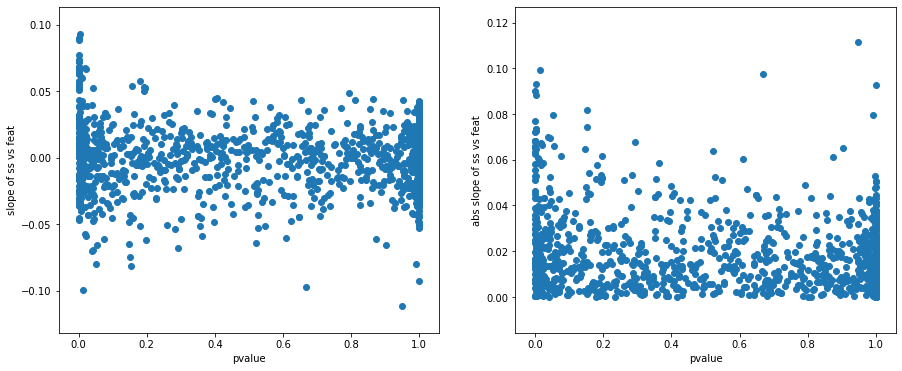

In [43]:
# scatter plot between pvalues (s>1.0) for each feature and the slope of (stabilityscore vs. feature) 
plt.figure(figsize = (15,6))

plt.subplot(1, 2, 1) 
plt.scatter(ss_pvals['s>10'], ss_pvals['norm_slope'])
plt.xlabel('pvalue')
plt.ylabel('slope of ss vs feat')

plt.subplot(1, 2, 2) 
plt.scatter(ss_pvals['s>10'], ss_pvals['abs_norm'])
plt.xlabel('pvalue')
plt.ylabel('abs slope of ss vs feat')

Text(0, 0.5, 'abs slope of ss vs feat')

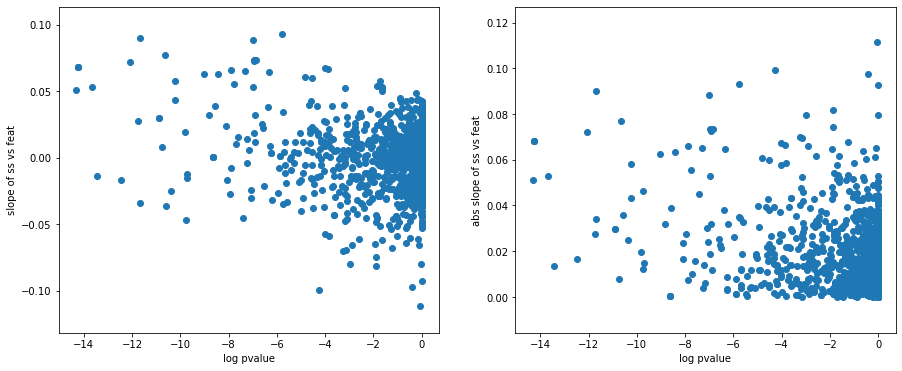

In [44]:
# scatter plot between pvalues (s>1.0) for each feature and the slope of (stabilityscore vs. feature) 
plt.figure(figsize = (15,6))

plt.subplot(1, 2, 1) 
plt.scatter(np.log(ss_pvals['s>10']), ss_pvals['norm_slope'])
plt.xlabel('log pvalue')
plt.ylabel('slope of ss vs feat')

plt.subplot(1, 2, 2) 
plt.scatter(np.log(ss_pvals['s>10']), ss_pvals['abs_norm'])
plt.xlabel('log pvalue')
plt.ylabel('abs slope of ss vs feat')

In [55]:
ss_pvals.sort_values('norm_slope')

,feature,s>06,s>07,s>08,s>09,s>10,norm_slope,abs_norm
596,freq_KR,2.559874e-02,4.839774e-01,1.458893e-01,7.310600e-01,0.948793,-0.111280,0.111280
830,helices_freq_T,3.358630e-05,3.028991e-04,2.552016e-04,1.748939e-03,0.014106,-0.099384,0.099384
1225,n_RT_3d_contacts_3A,2.024184e-02,7.814673e-02,7.948889e-02,6.696180e-01,0.668160,-0.097484,0.097484
1044,n_GR_3d_contacts_5A,6.508006e-04,7.300352e-02,1.384337e-01,9.962105e-01,1.000000,-0.092855,0.092855
1226,n_RT_3d_contacts_5A,2.062410e-06,4.029476e-05,1.014295e-04,3.116647e-02,0.152720,-0.081756,0.081756
...,...,...,...,...,...,...,...,...
1379,percent_hydrophobic_AFILMVWY,1.429982e-03,8.254224e-04,1.629661e-04,3.636796e-04,0.000946,0.073634,0.073634
419,exposed_np_AFILMVWY,2.038800e-07,4.551173e-05,1.541001e-05,2.572918e-05,0.000024,0.077143,0.077143
7,abego_res_profile,3.048804e-05,1.879631e-04,1.168211e-05,1.354548e-04,0.000905,0.088327,0.088327
824,helices_freq_L,4.551914e-15,2.459709e-10,6.094014e-13,2.072999e-07,0.000008,0.089986,0.089986


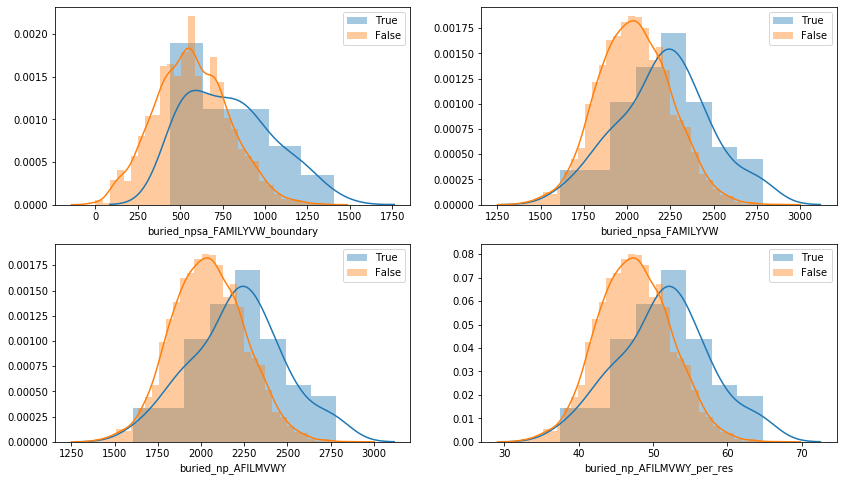

In [56]:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1) 
sns.distplot(df.query('stable_10 == True')['buried_npsa_FAMILYVW_boundary'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_npsa_FAMILYVW_boundary'], label = 'False')
plt.xlabel('buried_npsa_FAMILYVW_boundary', fontsize = 10)
plt.legend()

plt.subplot(2, 2, 2) 
sns.distplot(df.query('stable_10 == True')['buried_npsa_FAMILYVW'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_npsa_FAMILYVW'], label = 'False')
plt.xlabel('buried_npsa_FAMILYVW')
plt.legend()

plt.subplot(2, 2, 3) 
sns.distplot(df.query('stable_10 == True')['buried_np_AFILMVWY'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_np_AFILMVWY'], label = 'False')
plt.xlabel('buried_np_AFILMVWY')
plt.legend()

plt.subplot(2, 2, 4) 
sns.distplot(df.query('stable_10 == True')['buried_np_AFILMVWY_per_res'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_np_AFILMVWY_per_res'], label = 'False')
plt.xlabel('buried_np_AFILMVWY_per_res')
plt.legend()

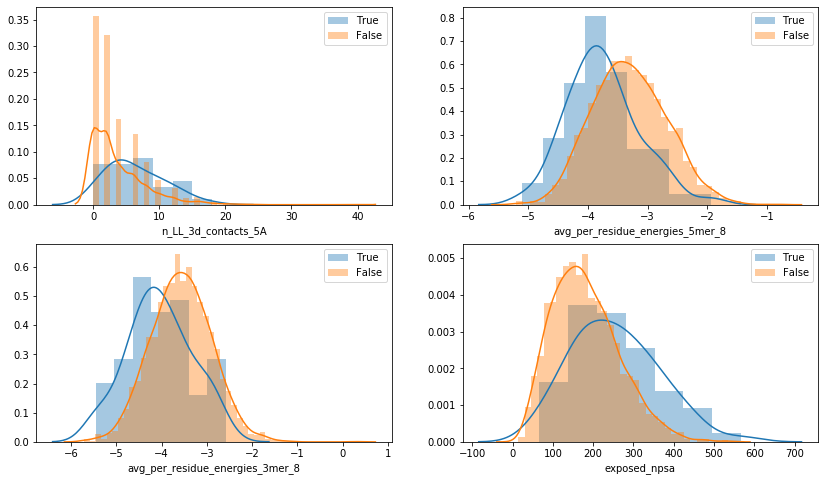

In [47]:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1) 
sns.distplot(df.query('stable_10 == True')['hydrophobicity'], label = 'True')
sns.distplot(df.query('stable_10 == False')['hydrophobicity'], label = 'False')
plt.xlabel('hydrophobicity', fontsize = 10)
plt.legend()

plt.subplot(2, 2, 2) 
sns.distplot(df.query('stable_10 == True')['avg_per_residue_energies_5mer_8'], label = 'True')
sns.distplot(df.query('stable_10 == False')['avg_per_residue_energies_5mer_8'], label = 'False')
plt.xlabel('avg_per_residue_energies_5mer_8')
plt.legend()

plt.subplot(2, 2, 3) 
sns.distplot(df.query('stable_10 == True')['avg_per_residue_energies_3mer_8'], label = 'True')
sns.distplot(df.query('stable_10 == False')['avg_per_residue_energies_3mer_8'], label = 'False')
plt.xlabel('avg_per_residue_energies_3mer_8')
plt.legend()

plt.subplot(2, 2, 4) 
sns.distplot(df.query('stable_10 == True')['exposed_npsa'], label = 'True')
sns.distplot(df.query('stable_10 == False')['exposed_npsa'], label = 'False')
plt.xlabel('exposed_npsa')
plt.legend()

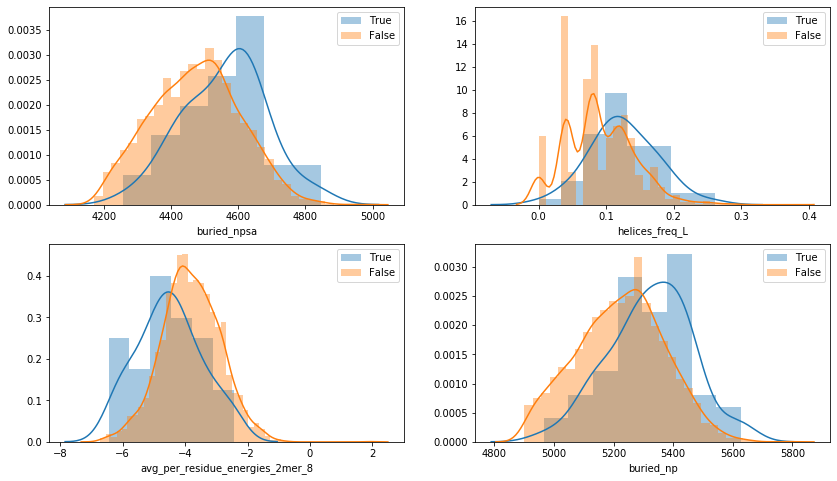

In [49]:
plt.figure(figsize = (14, 8))

plt.subplot(2, 2, 1) 
sns.distplot(df.query('stable_10 == True')['buried_npsa'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_npsa'], label = 'False')
plt.xlabel('buried_npsa', fontsize = 10)
plt.legend()

plt.subplot(2, 2, 2) 
sns.distplot(df.query('stable_10 == True')['helices_freq_L'], label = 'True')
sns.distplot(df.query('stable_10 == False')['helices_freq_L'], label = 'False')
plt.xlabel('helices_freq_L')
plt.legend()

plt.subplot(2, 2, 3) 
sns.distplot(df.query('stable_10 == True')['avg_per_residue_energies_2mer_8'], label = 'True')
sns.distplot(df.query('stable_10 == False')['avg_per_residue_energies_2mer_8'], label = 'False')
plt.xlabel('avg_per_residue_energies_2mer_8')
plt.legend()

plt.subplot(2, 2, 4) 
sns.distplot(df.query('stable_10 == True')['buried_np'], label = 'True')
sns.distplot(df.query('stable_10 == False')['buried_np'], label = 'False')
plt.xlabel('buried_np')
plt.legend()